## 1. Getting the data

See this notebook for details on downloading the data: [Downloading the data](./download_dataset.ipynb)


In [1]:
from utils.download_dataset import download_and_extract_zip

bulldozer_dataset_path = download_and_extract_zip()

bulldozer_dataset_path

[INFO] data/bulldozer directory exists, skipping download.


PosixPath('data/bulldozer')

## 2. EDA

See this notebook for EDA and data cleaning: [Exploratory Data Analysis](./eda.ipynb)


In [2]:
import pandas as pd

# Import train samples (making sure to parse dates and then sort by them)
train_df = pd.read_csv(
    filepath_or_buffer="data/bulldozer/Train.csv",
    parse_dates=["saledate"],
    low_memory=False,
).sort_values(by="saledate", ascending=True)

# Import validation samples (making sure to parse dates and then sort by them)
valid_df = pd.read_csv(
    filepath_or_buffer="data/bulldozer/Valid.csv", parse_dates=["saledate"]
)

# The ValidSolution.csv contains the SalePrice values for the samples in Valid.csv
valid_solution = pd.read_csv(filepath_or_buffer="data/bulldozer/ValidSolution.csv")

In [3]:
# Map valid_solution to valid_df
valid_df["SalePrice"] = valid_df["SalesID"].map(
    valid_solution.set_index("SalesID")["SalePrice"]
)

# Make sure valid_df is sorted by saledate still
valid_df = valid_df.sort_values("saledate", ascending=True).reset_index(drop=True)

# How many samples are in each DataFrame?
print(f"[INFO] Number of samples in training DataFrame: {len(train_df)}")
print(f"[INFO] Number of samples in validation DataFrame: {len(valid_df)}")

[INFO] Number of samples in training DataFrame: 401125
[INFO] Number of samples in validation DataFrame: 11573


In [4]:
# Make a function to add date columns
def add_datetime_features_to_df(df, date_column="saledate"):
    # Add datetime parameters for saledate
    df["saleYear"] = df[date_column].dt.year
    df["saleMonth"] = df[date_column].dt.month
    df["saleDay"] = df[date_column].dt.day
    df["saleDayofweek"] = df[date_column].dt.dayofweek
    df["saleDayofyear"] = df[date_column].dt.dayofyear

    # Drop original saledate column
    df.drop("saledate", axis=1, inplace=True)

    return df


train_df = add_datetime_features_to_df(df=train_df)
valid_df = add_datetime_features_to_df(df=valid_df)

In [5]:
# Display the last 5 columns (the recently added datetime breakdowns)
train_df.iloc[:, -5:].sample(5)

,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
68274,1998,6,25,3,176
309559,2010,3,16,1,75
187119,2002,6,19,2,170
397838,2011,12,16,4,350
300250,2009,10,14,2,287


In [6]:
# Split training data into features and labels
X_train = train_df.drop("SalePrice", axis=1)
y_train = train_df["SalePrice"]

# Split validation data into features and labels
X_valid = valid_df.drop("SalePrice", axis=1)
y_valid = valid_df["SalePrice"]

In [7]:
# Define numerical and categorical features
numerical_features = [
    label
    for label, content in X_train.items()
    if pd.api.types.is_numeric_dtype(content)
]
categorical_features = [
    label
    for label, content in X_train.items()
    if not pd.api.types.is_numeric_dtype(content)
]

print(f"[INFO] Numeric features: {numerical_features}")
print(f"[INFO] Categorical features: {categorical_features[:10]}...")

[INFO] Numeric features: ['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'saleYear', 'saleMonth', 'saleDay', 'saleDayofweek', 'saleDayofyear']
[INFO] Categorical features: ['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup']...


In [8]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

# 1. Create an ordinal encoder (turns category items into numeric representation)
ordinal_encoder = OrdinalEncoder(
    categories="auto",
    handle_unknown="use_encoded_value",
    unknown_value=np.nan,
    encoded_missing_value=np.nan,
)  # treat unknown categories as np.nan (or None)

# 2. Fit and transform the categorical columns of X_train
X_train_preprocessed = (
    X_train.copy()
)  # make copies of the oringal DataFrames so we can keep the original values in tact and view them later
X_train_preprocessed[categorical_features] = ordinal_encoder.fit_transform(
    X_train_preprocessed[categorical_features].astype(str)
)  # OrdinalEncoder expects all values as the same type (e.g. string or numeric only)

# 3. Transform the categorical columns of X_valid
X_valid_preprocessed = X_valid.copy()
X_valid_preprocessed[categorical_features] = ordinal_encoder.transform(
    X_valid_preprocessed[categorical_features].astype(str)
)  # only use `transform` on the validation data

In [9]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
205615,1646770,1126363,8434,132,18.0,1974,NaN,NaN,TD20,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
92803,1404019,1169900,7110,132,99.0,1986,NaN,NaN,416,416,...,NaN,NaN,NaN,NaN,NaN,1989,1,31,1,31
98346,1415646,1262088,3357,132,99.0,1975,NaN,NaN,12G,12,...,NaN,NaN,NaN,NaN,NaN,1989,1,31,1,31
169297,1596358,1433229,8247,132,99.0,1978,NaN,NaN,644,644,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
274835,1821514,1194089,10150,132,99.0,1980,NaN,NaN,A66,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31


In [10]:
X_train_preprocessed.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
205615,1646770,1126363,8434,132,18.0,1974,NaN,3.0,4536.0,1734.0,...,0.0,7.0,5.0,4.0,5.0,1989,1,17,1,17
92803,1404019,1169900,7110,132,99.0,1986,NaN,3.0,734.0,242.0,...,2.0,10.0,7.0,4.0,5.0,1989,1,31,1,31
98346,1415646,1262088,3357,132,99.0,1975,NaN,3.0,81.0,18.0,...,2.0,10.0,7.0,4.0,5.0,1989,1,31,1,31
169297,1596358,1433229,8247,132,99.0,1978,NaN,3.0,1157.0,348.0,...,2.0,10.0,7.0,3.0,1.0,1989,1,31,1,31
274835,1821514,1194089,10150,132,99.0,1980,NaN,3.0,1799.0,556.0,...,2.0,10.0,7.0,3.0,1.0,1989,1,31,1,31


In [11]:
X_train[categorical_features].isna().sum().sort_values(ascending=False)[:10]

Engine_Horsepower    375906
Blade_Extension      375906
Tip_Control          375906
Pushblock            375906
Enclosure_Type       375906
Blade_Width          375906
Scarifier            375895
Hydraulics_Flow      357763
Grouser_Tracks       357763
Coupler_System       357667
dtype: int64

In [12]:
X_train_preprocessed[categorical_features].isna().sum().sort_values(ascending=False)[
    :10
]

UsageBand         0
fiModelDesc       0
Pushblock         0
Ripper            0
Scarifier         0
Tip_Control       0
Tire_Size         0
Coupler           0
Coupler_System    0
Grouser_Tracks    0
dtype: int64

In [13]:
# Let's inspect the first three categories
ordinal_encoder.categories_[:3]

[array(['High', 'Low', 'Medium', 'nan'], dtype=object),
 array(['100C', '104', '1066', ..., 'ZX800LC', 'ZX80LCK', 'ZX850H'],
       shape=(4999,), dtype=object),
 array(['10', '100', '104', ..., 'ZX80', 'ZX800', 'ZX850'],
       shape=(1950,), dtype=object)]

In [14]:
# Create a dictionary of dictionaries mapping column names and their variables to their numerical encoding
column_to_category_mapping = {}

for column_name, category_values in zip(
    categorical_features, ordinal_encoder.categories_
):
    int_to_category = {i: category for i, category in enumerate(category_values)}
    column_to_category_mapping[column_name] = int_to_category

# Inspect an example column name to category mapping
column_to_category_mapping["UsageBand"]

{0: 'High', 1: 'Low', 2: 'Medium', 3: 'nan'}

In [15]:
# Create a copy of the preprocessed DataFrame
X_train_unprocessed = X_train_preprocessed[categorical_features].copy()

# This will return an array of the original untransformed data
X_train_unprocessed = ordinal_encoder.inverse_transform(X_train_unprocessed)

# Turn back into a DataFrame for viewing pleasure
X_train_unprocessed_df = pd.DataFrame(X_train_unprocessed, columns=categorical_features)

# Check out a sample
X_train_unprocessed_df.sample(5)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
78743,Medium,312,312,nan,nan,nan,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Connecticut,TEX,...,20 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,nan,nan,nan,nan,nan
343585,nan,345BIIL,345,B,II,L,Large / Medium,"Hydraulic Excavator, Track - 40.0 to 50.0 Metr...",Tennessee,TEX,...,36 inch,None or Unspecified,None or Unspecified,Yes,Triple,nan,nan,nan,nan,nan
117279,nan,FR10B,FR10,B,nan,nan,nan,Wheel Loader - 100.0 to 110.0 Horsepower,South Carolina,WL,...,nan,nan,nan,nan,nan,nan,nan,nan,Standard,Conventional
188718,nan,621B,621,B,nan,nan,nan,Wheel Loader - 120.0 to 135.0 Horsepower,Illinois,WL,...,nan,nan,nan,nan,nan,nan,nan,nan,Standard,Conventional
389591,nan,320CL,320,C,nan,L,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",Texas,TEX,...,None or Unspecified,"9' 8""",Manual,Yes,Double,nan,nan,nan,nan,nan


In [16]:
%%time

from sklearn.ensemble import RandomForestRegressor

# Instantiate a Random Forest Regression model
model = RandomForestRegressor(n_jobs=-1)

# Fit the model to the preprocessed training data
model.fit(
	X=X_train_preprocessed,
    y=y_train
)

CPU times: user 8min 50s, sys: 2.92 s, total: 8min 53s
Wall time: 1min 12s


RandomForestRegressor(n_jobs=-1)

In [17]:
%%time

# Check model performance on the validation set
model.score(
	X=X_valid_preprocessed,
	y=y_valid
)

CPU times: user 443 ms, sys: 71.6 ms, total: 514 ms
Wall time: 86.8 ms


0.8710638859734076

In [18]:
%%time

# Check model performance on the training set
model.score(
	X=X_train_preprocessed,
	y=y_train
)

CPU times: user 14.8 s, sys: 185 ms, total: 15 s
Wall time: 2.19 s


0.9872763656487832

In [19]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error


# Create function to evaluate our model
def show_scores(
    model,
    train_features=X_train_preprocessed,
    train_labels=y_train,
    valid_features=X_valid_preprocessed,
    valid_labels=y_valid,
):

    # Make predictions on train and validation features
    train_preds = model.predict(X=train_features)
    val_preds = model.predict(X=valid_features)

    # Create a scores dictionary of different evaluation metrics
    scores = {
        "Training MAE": mean_absolute_error(y_true=train_labels, y_pred=train_preds),
        "Valid MAE": mean_absolute_error(y_true=valid_labels, y_pred=val_preds),
        "Training RMSLE": root_mean_squared_log_error(
            y_true=train_labels, y_pred=train_preds
        ),
        "Valid RMSLE": root_mean_squared_log_error(
            y_true=valid_labels, y_pred=val_preds
        ),
        "Training R^2": model.score(X=train_features, y=train_labels),
        "Valid R^2": model.score(X=valid_features, y=valid_labels),
    }
    return scores

In [20]:
# Try our model scoring function out
model_scores = show_scores(model=model)
model_scores

{'Training MAE': 1594.8282986350887,
 'Valid MAE': 6166.832920879057,
 'Training RMSLE': 0.08535195541601255,
 'Valid RMSLE': 0.25711166679544145,
 'Training R^2': 0.9872763656487832,
 'Valid R^2': 0.8710638859734076}

In [21]:
%%time

# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, # this is the default
                              n_jobs=-1,
                              max_samples=10000) # each estimator sees max_samples (the default is to see all available samples)

# Cutting down the max number of samples each tree can see improves training time
model.fit(
	X_train_preprocessed, 
	y_train
)

CPU times: user 18.8 s, sys: 156 ms, total: 18.9 s
Wall time: 2.74 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [22]:
# Get evaluation metrics from reduced sample model
base_model_scores = show_scores(model=model)
base_model_scores

{'Training MAE': 5602.318264497766,
 'Valid MAE': 7190.484687346985,
 'Training RMSLE': 0.26027597185345624,
 'Valid RMSLE': 0.2942680158110727,
 'Training R^2': 0.8583656323499352,
 'Valid R^2': 0.8282390477694647}

In [23]:
%%time

from sklearn.model_selection import GridSearchCV

# 1. Define a dictionary with different values for RandomForestRegressor hyperparameters
# Documatation for potential different values - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html 

param_grid = {
	"n_estimators": np.arange(50, 100, 10),
	"max_depth": [None, 10, 20],
	"min_samples_split": [4, 5],
	"min_samples_leaf": [1, 2],
	"max_features": [0.5, 1.0, "sqrt"],
	"max_samples": [10000]
}

# 2. Setup instance of GridSearchCV to explore different parameters 
gs_model = GridSearchCV(
	estimator=RandomForestRegressor(),
	param_grid=param_grid,
	cv=3,
	verbose=1,
	n_jobs=-1
)

# 3. Fit the model using a series of different hyperparameter values
gs_model.fit(
	X=X_train_preprocessed, 
    y=y_train
)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


/Volumes/NAS/Projects/Machine-Learning/regression/bluebook-for-bulldozers/env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 7.38 s, sys: 1.8 s, total: 9.18 s
Wall time: 8min 44s


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': [0.5, 1.0, 'sqrt'],
                         'max_samples': [10000], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [4, 5],
                         'n_estimators': array([50, 60, 70, 80, 90])},
             verbose=1)

In [60]:
# Find the best parameters from GridSearchCV
gs_model.best_params_

{'max_depth': None,
 'max_features': 0.5,
 'max_samples': 10000,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': np.int64(80)}

In [61]:
# Evaluate the GridSearchCV model
gs_model_scores = show_scores(gs_model)
gs_model_scores

{'Training MAE': 5805.954420625027,
 'Valid MAE': 7303.5642728816665,
 'Training RMSLE': 0.26755819063334263,
 'Valid RMSLE': 0.3012036916704367,
 'Training R^2': 0.8504258197362702,
 'Valid R^2': 0.8299027103358568}

In [62]:
%%time

# Create a model with best found hyperparameters 
ideal_model = RandomForestRegressor(n_estimators=80,
                                    max_depth=None,
                                    min_samples_leaf=1,
                                    min_samples_split=5,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)

# Fit a model to the preprocessed data
ideal_model.fit(X=X_train_preprocessed, 
                y=y_train)

CPU times: user 3min 30s, sys: 1.33 s, total: 3min 32s
Wall time: 28.7 s


RandomForestRegressor(max_features=0.5, min_samples_split=5, n_estimators=80,
                      n_jobs=-1)

In [63]:
%%time

# Evaluate ideal model
ideal_model_scores = show_scores(model=ideal_model)
ideal_model_scores

CPU times: user 18.9 s, sys: 196 ms, total: 19.1 s
Wall time: 2.71 s


{'Training MAE': 1961.2603665694885,
 'Valid MAE': 5972.376827272392,
 'Training RMSLE': 0.10242788109561295,
 'Valid RMSLE': 0.2478930947597441,
 'Training R^2': 0.9809088318954359,
 'Valid R^2': 0.88083576144193}

In [64]:
%%time

# Halve the number of estimators
fast_model = RandomForestRegressor(n_estimators=45,
                                   max_depth=None,
                                   min_samples_leaf=1,
                                   min_samples_split=5,
                                   max_features=0.5,
                                   n_jobs=-1,
                                   max_samples=None)

# Fit the faster model to the data
fast_model.fit(X=X_train_preprocessed, 
               y=y_train)

CPU times: user 1min 58s, sys: 769 ms, total: 1min 59s
Wall time: 16.9 s


RandomForestRegressor(max_features=0.5, min_samples_split=5, n_estimators=45,
                      n_jobs=-1)

In [65]:
%%time

# Get results from the fast model
fast_model_scores = show_scores(model=fast_model)
fast_model_scores

CPU times: user 10.4 s, sys: 133 ms, total: 10.5 s
Wall time: 1.59 s


{'Training MAE': 1986.976036357173,
 'Valid MAE': 5992.538165301932,
 'Training RMSLE': 0.1035943121250271,
 'Valid RMSLE': 0.24917502280805495,
 'Training R^2': 0.9803161748379234,
 'Valid R^2': 0.8795766184863005}

In [66]:
# Add names of models to dictionaries
base_model_scores["model_name"] = "default_model"
gs_model_scores["model_name"] = "random_search_model"
ideal_model_scores["model_name"] = "ideal_model"
fast_model_scores["model_name"] = "fast_model"

# Turn all model score dictionaries into a list
all_model_scores = [
    base_model_scores,
    gs_model_scores,
    ideal_model_scores,
    fast_model_scores,
]

# Create DataFrame and sort model scores by validation RMSLE
model_comparison_df = pd.DataFrame(all_model_scores).sort_values(
    by="Valid RMSLE", ascending=False
)
model_comparison_df.head()

,Training MAE,Valid MAE,Training RMSLE,Valid RMSLE,Training R^2,Valid R^2,model_name
1,5805.954421,7303.564273,0.267558,0.301204,0.850426,0.829903,random_search_model
0,5602.318264,7190.484687,0.260276,0.294268,0.858366,0.828239,default_model
3,1986.976036,5992.538165,0.103594,0.249175,0.980316,0.879577,fast_model
2,1961.260367,5972.376827,0.102428,0.247893,0.980909,0.880836,ideal_model


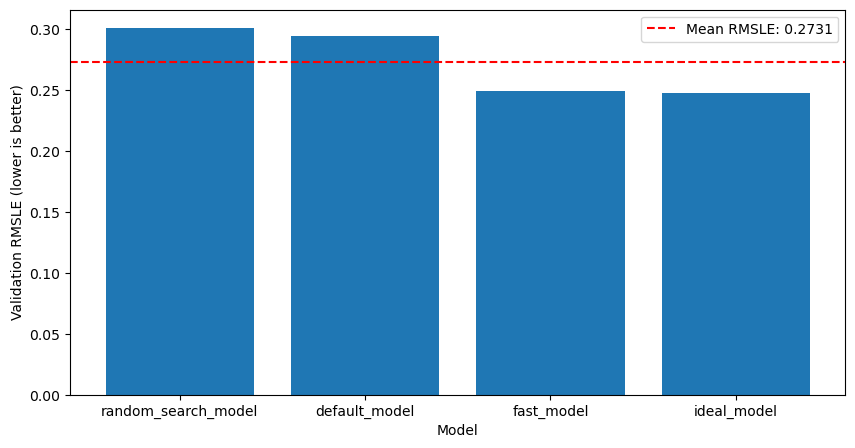

In [67]:
import matplotlib.pyplot as plt

# Get mean RSMLE score of all models
mean_rsmle_score = model_comparison_df["Valid RMSLE"].mean()

# Plot validation RMSLE against each other
plt.figure(figsize=(10, 5))
plt.bar(
    x=model_comparison_df["model_name"],
    height=model_comparison_df["Valid RMSLE"].values,
)
plt.xlabel("Model")
plt.ylabel("Validation RMSLE (lower is better)")
plt.xticks(rotation=0, fontsize=10)
plt.axhline(
    y=mean_rsmle_score,
    color="red",
    linestyle="--",
    label=f"Mean RMSLE: {mean_rsmle_score:.4f}",
)
plt.legend()

In [68]:
import joblib

bulldozer_price_prediction_model_name = "models/randomforest_regressor_best_RMSLE.pkl"

# Save model to file
joblib.dump(value=ideal_model, filename=bulldozer_price_prediction_model_name)

['models/randomforest_regressor_best_RMSLE.pkl']

In [69]:
# Load the best model
best_model = joblib.load(filename=bulldozer_price_prediction_model_name)
best_model

RandomForestRegressor(max_features=0.5, min_samples_split=5, n_estimators=80,
                      n_jobs=-1)

In [70]:
# Confirm that the model works
best_model_scores = show_scores(model=best_model)
best_model_scores

{'Training MAE': 1961.2603665694885,
 'Valid MAE': 5972.376827272392,
 'Training RMSLE': 0.10242788109561295,
 'Valid RMSLE': 0.2478930947597441,
 'Training R^2': 0.9809088318954359,
 'Valid R^2': 0.88083576144193}

In [71]:
# See if loaded model and pre-saved model results are the same
# Note: these values may be very slightly different depending on how precise your computer stores values.
best_model_scores["Valid RMSLE"] == ideal_model_scores["Valid RMSLE"]

True

In [72]:
# Is the loaded model as good as the non-loaded model?
if np.isclose(
    a=best_model_scores["Valid RMSLE"], b=ideal_model_scores["Valid RMSLE"], atol=1e-4
):  # Make sure values are within 0.0001 of each other
    print(f"[INFO] Model results are close!")
else:
    print(f"[INFO] Model results aren't close, did something go wrong?")

[INFO] Model results are close!


In [73]:
# Load the test data
test_df = pd.read_csv(
    filepath_or_buffer="data/bulldozer/Test.csv", parse_dates=["saledate"]
)
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [74]:
# Preprocess test_df to have same columns as train_df (add the datetime features)
test_df = add_datetime_features_to_df(df=test_df)
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
0,1227829,1006309,3168,121,3,1999,3688.0,Low,580G,580,...,NaN,NaN,NaN,NaN,NaN,2012,5,3,3,124
1,1227844,1022817,7271,121,3,1000,28555.0,High,936,936,...,NaN,NaN,NaN,Standard,Conventional,2012,5,10,3,131
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,EC210BLC,EC210,...,NaN,NaN,NaN,NaN,NaN,2012,5,10,3,131
3,1227848,56204,1269,121,3,2006,8940.0,High,330CL,330,...,NaN,NaN,NaN,NaN,NaN,2012,5,10,3,131
4,1227863,1053887,22312,121,3,2005,2286.0,Low,650K,650,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,5,10,3,131


In [75]:
# Try to predict with model
# test_preds = best_model.predict(test_df)

In [76]:
# Create a copy of the test DataFrame to keep the original intact
test_df_preprocessed = test_df.copy()

# Transform the categorical features of the test DataFrame into numbers
test_df_preprocessed[categorical_features] = ordinal_encoder.transform(
    test_df_preprocessed[categorical_features].astype(str)
)
test_df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  2129 non-null   float64
 7   UsageBand                 12457 non-null  float64
 8   fiModelDesc               12349 non-null  float64
 9   fiBaseModel               12431 non-null  float64
 10  fiSecondaryDesc           12449 non-null  float64
 11  fiModelSeries             12456 non-null  float64
 12  fiModelDescriptor         12452 non-null  float64
 13  ProductSize               12457 non-null  float64
 14  fiProd

In [77]:
# Make predictions on the preprocessed test data
test_preds = best_model.predict(test_df_preprocessed)

In [78]:
# Check the first 10 test predictions
test_preds[:10]

array([14927.565386  , 32534.11548521, 48441.06646825, 98056.93452381,
       27304.82886905, 30094.09474206, 25516.5922619 , 20141.98841089,
       17706.95486111, 30864.85615079])

In [79]:
# Check number of test predictions
test_preds.shape, test_df.shape

((12457,), (12457, 56))

In [80]:
# Create DataFrame compatible with Kaggle submission requirements
pred_df = pd.DataFrame()
pred_df["SalesID"] = test_df["SalesID"]
pred_df["SalePrice"] = test_preds
pred_df.sample(5)

,SalesID,SalePrice
8509,6441346,45923.350694
1402,4316635,22036.227183
3587,6265577,74616.899802
7087,6312120,11481.685606
10543,6625514,37140.572917


In [81]:
# Export test dataset predictions to CSV
pred_df.to_csv("data/bulldozer/predictions.csv", index=False)

In [82]:
# Get example from test_df
test_df_preprocessed_sample = test_df_preprocessed.sample(n=1, random_state=42)

# Turn back into original format
test_df_unpreprocessed_sample = test_df_preprocessed_sample.copy()
test_df_unpreprocessed_sample[categorical_features] = ordinal_encoder.inverse_transform(
    test_df_unpreprocessed_sample[categorical_features]
)
test_df_unpreprocessed_sample.to_dict(orient="records")

[{'SalesID': 1229148,
  'MachineID': 1042578,
  'ModelID': 9579,
  'datasource': 121,
  'auctioneerID': 3,
  'YearMade': 2004,
  'MachineHoursCurrentMeter': 3290.0,
  'UsageBand': 'Medium',
  'fiModelDesc': 'S250',
  'fiBaseModel': 'S250',
  'fiSecondaryDesc': 'nan',
  'fiModelSeries': 'nan',
  'fiModelDescriptor': 'nan',
  'ProductSize': 'nan',
  'fiProductClassDesc': 'Skid Steer Loader - 2201.0 to 2701.0 Lb Operating Capacity',
  'state': 'Missouri',
  'ProductGroup': 'SSL',
  'ProductGroupDesc': 'Skid Steer Loaders',
  'Drive_System': 'nan',
  'Enclosure': 'EROPS',
  'Forks': 'None or Unspecified',
  'Pad_Type': 'nan',
  'Ride_Control': 'nan',
  'Stick': 'nan',
  'Transmission': 'nan',
  'Turbocharged': 'nan',
  'Blade_Extension': 'nan',
  'Blade_Width': 'nan',
  'Enclosure_Type': 'nan',
  'Engine_Horsepower': 'nan',
  'Hydraulics': 'Auxiliary',
  'Pushblock': 'nan',
  'Ripper': 'nan',
  'Scarifier': 'nan',
  'Tip_Control': 'nan',
  'Tire_Size': 'nan',
  'Coupler': 'Hydraulic',
  'C

In [83]:
# Make a prediction on the preprocessed test sample
best_model.predict(test_df_preprocessed_sample)

array([13115.98710317])

In [84]:
# Create a dictionary of features and values from an internet-based bulldozer advertisement
# See link: https://www.purplewave.com/auction/240606/item/EK8504/2004-Caterpillar-D6R_XL-Crawlers-Crawler_Dozer-Missouri
custom_sample = {
    "SalesID": np.nan,
    "MachineID": 8504,
    "ModelID": np.nan,
    "datasource": np.nan,
    "auctioneerID": np.nan,
    "YearMade": 2004,
    "MachineHoursCurrentMeter": 11770.0,
    "UsageBand": "High",
    "fiModelDesc": "D6RXL",
    "fiBaseModel": "D6",
    "fiSecondaryDesc": "XL",
    "fiModelSeries": np.nan,
    "fiModelDescriptor": np.nan,
    "ProductSize": "Medium",
    "fiProductClassDesc": "Track Type Tractor, Dozer - 130.0 to 160.0 Horsepower",
    "state": "Missouri",
    "ProductGroup": "TTT",
    "ProductGroupDesc": "Track Type Tractors",
    "Drive_System": "No",
    "Enclosure": "EROPS",
    "Forks": "None or Unspecified",
    "Pad_Type": "Grouser",
    "Ride_Control": "None or Unspecified",
    "Stick": "nan",
    "Transmission": "Powershift",
    "Turbocharged": "None or Unspecified",
    "Blade_Extension": "None or Unspecified",
    "Blade_Width": np.nan,
    "Enclosure_Type": np.nan,
    "Engine_Horsepower": np.nan,
    "Hydraulics": np.nan,
    "Pushblock": "None or Unspecified",
    "Ripper": "None or Unspecified",
    "Scarifier": "None or Unspecified",
    "Tip_Control": "Tip",
    "Tire_Size": np.nan,
    "Coupler": np.nan,
    "Coupler_System": np.nan,
    "Grouser_Tracks": "Yes",
    "Hydraulics_Flow": np.nan,
    "Track_Type": "Steel",
    "Undercarriage_Pad_Width": "22 inch",
    "Stick_Length": np.nan,
    "Thumb": np.nan,
    "Pattern_Changer": np.nan,
    "Grouser_Type": "Single",
    "Backhoe_Mounting": "None or Unspecified",
    "Blade_Type": "Semi U",
    "Travel_Controls": np.nan,
    "Differential_Type": np.nan,
    "Steering_Controls": "Command Control",
    "saleYear": 2024,
    "saleMonth": 6,
    "saleDay": 7,
    "saleDayofweek": 5,
    "saleDayofyear": 159,
}

In [85]:
# Turn single sample in a DataFrame
custom_sample_df = pd.DataFrame(custom_sample, index=[0])
custom_sample_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
0,NaN,8504,NaN,NaN,NaN,2004,11770.0,High,D6RXL,D6,...,None or Unspecified,Semi U,NaN,NaN,Command Control,2024,6,7,5,159


In [86]:
# Transform the categorical features of the custom sample
custom_sample_df[categorical_features] = ordinal_encoder.transform(
    custom_sample_df[categorical_features].astype(str)
)
custom_sample_df

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
0,NaN,8504,NaN,NaN,NaN,2004,11770.0,0.0,2308.0,703.0,...,0.0,6.0,7.0,4.0,0.0,2024,6,7,5,159


In [87]:
# Make a prediction on the preprocessed custom sample
custom_sample_pred = best_model.predict(custom_sample_df)
print(
    f"[INFO] Predicted sale price of custom sample: ${round(custom_sample_pred[0], 2)}"
)

[INFO] Predicted sale price of custom sample: $53625.48


In [88]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error

# Evaluate our model versus the actual sale price
custom_sample_actual_sale_price = [
    72600
]  # this is the sale price listed on the advertisement

print(
    f"[INFO] Model MAE on custom sample: {mean_absolute_error(y_pred=custom_sample_pred, y_true=custom_sample_actual_sale_price)}"
)
print(
    f"[INFO] Model RMSLE on custom sample: {root_mean_squared_log_error(y_pred=custom_sample_pred, y_true=custom_sample_actual_sale_price)}"
)

[INFO] Model MAE on custom sample: 18974.52103625542
[INFO] Model RMSLE on custom sample: 0.30293573922921624


In [89]:
# Find feature importance of our best model
best_model_feature_importances = best_model.feature_importances_
best_model_feature_importances

array([3.57655750e-02, 2.80429550e-02, 6.03946264e-02, 1.90449555e-03,
       5.25151135e-03, 1.97954304e-01, 6.57401022e-03, 1.40109873e-03,
       4.92089816e-02, 4.62431930e-02, 3.63343410e-02, 4.64450830e-03,
       2.90748658e-02, 1.61030363e-01, 4.65687289e-02, 8.34205969e-03,
       6.96447858e-03, 5.25996456e-03, 1.61233801e-03, 5.65929586e-02,
       9.86207290e-04, 1.28884731e-03, 3.03007077e-03, 1.86638915e-04,
       1.41659973e-03, 6.36586291e-04, 3.38332537e-03, 5.44247204e-03,
       5.89629356e-03, 1.69029896e-03, 4.56413935e-03, 5.19690291e-03,
       4.75947864e-03, 9.82209446e-04, 7.82714748e-04, 1.09691973e-02,
       1.73837764e-03, 1.79711809e-02, 1.08525402e-02, 9.76664255e-03,
       2.32997583e-03, 1.28401006e-03, 1.63041096e-03, 8.13878486e-04,
       6.50535366e-04, 7.53338528e-04, 7.26902043e-04, 2.35111938e-03,
       3.79524462e-03, 3.75482661e-04, 4.78396929e-04, 7.30254701e-02,
       5.43349919e-03, 8.53410121e-03, 4.44489877e-03, 1.26666546e-02])

In [90]:
print(
    f"[INFO] Number of feature importance values: {best_model_feature_importances.shape[0]}"
)
print(f"[INFO] Number of features in training dataset: {X_train_preprocessed.shape[1]}")

[INFO] Number of feature importance values: 56
[INFO] Number of features in training dataset: 56


In [91]:
# Create feature importance DataFrame
column_names = test_df.columns
feature_importance_df = pd.DataFrame(
    {
        "feature_names": column_names,
        "feature_importance": best_model_feature_importances,
    }
).sort_values(by="feature_importance", ascending=False)
feature_importance_df.head(10)

,feature_names,feature_importance
5,YearMade,0.197954
13,ProductSize,0.161030
51,saleYear,0.073025
2,ModelID,0.060395
19,Enclosure,0.056593
8,fiModelDesc,0.049209
14,fiProductClassDesc,0.046569
9,fiBaseModel,0.046243
10,fiSecondaryDesc,0.036334
0,SalesID,0.035766


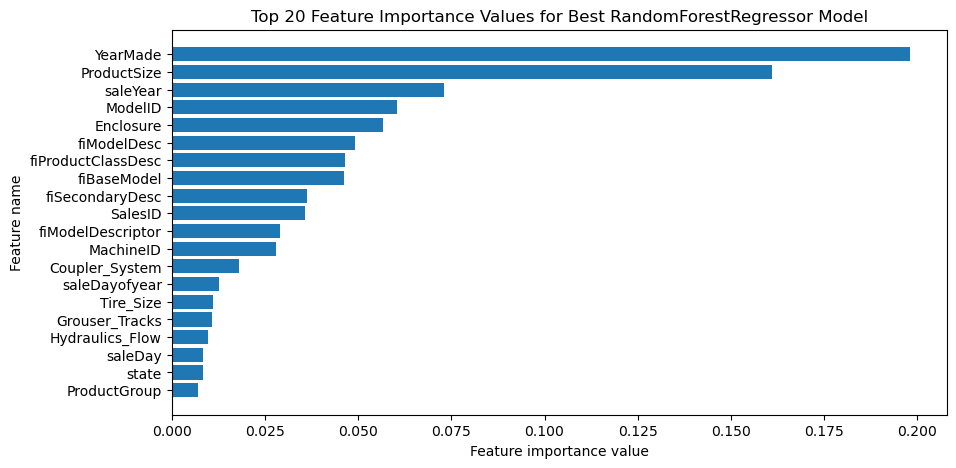

In [92]:
# Plot the top feature importance values
top_n = 20
plt.figure(figsize=(10, 5))
plt.barh(
    y=feature_importance_df["feature_names"][
        :top_n
    ],  # Plot the top_n feature importance values
    width=feature_importance_df["feature_importance"][:top_n],
)
plt.title(f"Top {top_n} Feature Importance Values for Best RandomForestRegressor Model")
plt.xlabel("Feature importance value")
plt.ylabel("Feature name")
plt.gca().invert_yaxis()

In [93]:
print(f"[INFO] Unique ProductSize values: {train_df['ProductSize'].unique()}")
print(f"[INFO] Unique Enclosure values: {train_df['Enclosure'].unique()}")

[INFO] Unique ProductSize values: ['Medium' nan 'Compact' 'Small' 'Large' 'Large / Medium' 'Mini']
[INFO] Unique Enclosure values: ['OROPS' 'EROPS' 'EROPS w AC' nan 'EROPS AC' 'NO ROPS'
 'None or Unspecified']
